# Titanic: Machine Learning from Disaster

This notebook is about the [Titanic Challenge](https://www.kaggle.com/c/titanic)

### Preps

In [179]:
# imports
import pandas as pd
import numpy as np
import random
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# functions I'll be using

def turn_factors_2_columns(df, target_col):
    "transforms one column of categorical data in several other columns with dummy values, better suited to regression"
    if target_col not in df.columns:
        print('{} not found in data'.format(target_col))
        return df
    # saving observed values possibilities
    possibilities = list(set([x if not pd.isnull(x)  else 'unkn' for x in df[target_col].values]))
    # creating dummies columns
    cat_df = pd.get_dummies(df[target_col], prefix=target_col)
    if sum(cat_df.apply('sum', axis=1).values) < cat_df.shape[0]:
        cat_df['_'.join([target_col,'unkn'])] = cat_df.apply(lambda x: abs(sum(x)-1), axis=1).values
    df2 = df.join(cat_df).copy()
    df2.drop(target_col, axis=1, inplace=True)
    # verifying if there is any missing possibility
    global CAT_VARS_GLOBAL
    if target_col in CAT_VARS_GLOBAL.keys():
        # printing if there is unconsistencies (var present in test data and not in train)
        for x in possibilities:
            if x not in CAT_VARS_GLOBAL[target_col]:
                print('found new value in this set of data: {}'.format(str(x)))
        # adding values to global archive - to use next time
        CAT_VARS_GLOBAL[target_col] = list(set(CAT_VARS_GLOBAL[target_col] + possibilities))
        # adding missing columns if it's the case
        for it in CAT_VARS_GLOBAL[target_col]:
            if '_'.join([target_col,it]) not in df2.columns:
                df2['_'.join([target_col,it])] = 0
    else:
        # adding values to global archive - to use next time
        CAT_VARS_GLOBAL[target_col] = possibilities
    return df2


def substrings_in_string(big_string, substrings):
    "finds the first substring in the big string"
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    return 'unkn'


def replace_titles(x):
    "groups several titles to the more usual ones"
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title


# def prepare_data(df):
#     "creates new variables and transforms categorical data into numeric"
#     df.index = df['PassengerId']
#     df.drop('PassengerId', axis=1, inplace=True)
#     # coudnt make an use of this column
#     df.drop('Ticket', axis=1, inplace=True)
#     # PCLASS : I believe this variable does not have a numerical meaning
#     replace_dict_pclass = {1:'fir', 2:'sec', 3:'thi'}
#     df['Pclass'] = df['Pclass'].replace(replace_dict_pclass)
#     df = turn_factors_2_columns(df=df, target_col='Pclass')
#     # TITLE
#     title_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
#                   'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
#                   'Don', 'Jonkheer']
#     df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
#     df.drop('Name', axis=1, inplace=True)
#     df['Title'] = df.apply(replace_titles, axis=1)
#     df = turn_factors_2_columns(df=df, target_col='Title')
#     # SEX
#     if 'Sex' in df.columns:
#         df = turn_factors_2_columns(df=df, target_col='Sex')
#     # since is binary we don't need two columns
#     df.drop('Sex_male', axis=1, inplace=True)
#     # turning cabin number into Deck
#     cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G','unkn']
#     df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
#     df.drop('Cabin', axis=1, inplace=True)
#     df = turn_factors_2_columns(df=df, target_col='Deck')
#     # embarked
#     df = turn_factors_2_columns(df=df, target_col='Embarked')
#     # new random variable
#     df['Family_Size']=df['SibSp']+df['Parch']
#     return df


def separate_xy(df, y_col):
    "transform dataframe into numpy arrays better suited to ML APIs"
    df_vars=df.columns.values.tolist()
    y_var=[y_col]
    X_vars=[i for i in df_vars if i not in y_var]
    return (df[X_vars].values, df[y_var].values)



In [46]:
# reading data
CAT_VARS_GLOBAL = {}
train_data_raw = pd.read_csv('data/kaggle_titanic_train.csv')
train_data_raw.index = train_data_raw['PassengerId']
test_data_raw = pd.read_csv('data/kaggle_titanic_test.csv')
test_data_raw.index = test_data_raw['PassengerId']

In [47]:
train_data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,,
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploring

In [48]:
# creating dataframe for testing and exploring purposes
dfx = train_data_raw.copy()

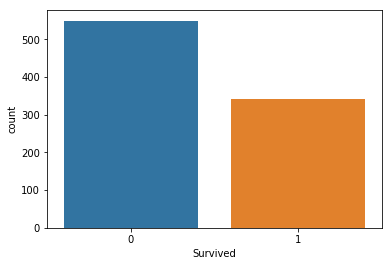

In [49]:
# Survived -> 0 = No, 1 = Yes
ax = sns.countplot(x='Survived', data=dfx)

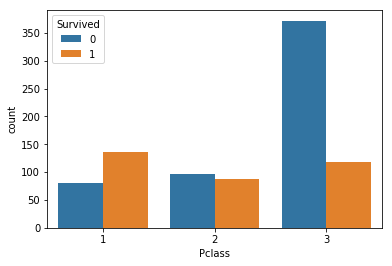

In [50]:
#  PClass - Ticket class -> 1 = 1st, 2 = 2nd, 3 = 3rd
ax = sns.countplot(x='Pclass', hue='Survived', data=dfx)
# are the classes distant by one unit of measurement?
# todo: test categorical vs numerical

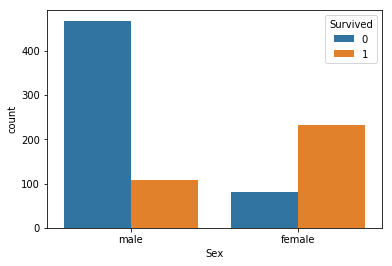

In [51]:
#  Sex
ax = sns.countplot(x='Sex', hue='Survived', data=dfx)
# since there are just 2 classes, turn into numerical

/home/tsk/.virtualenvs/jupyter/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/tsk/.virtualenvs/jupyter/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/tsk/.virtualenvs/jupyter/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


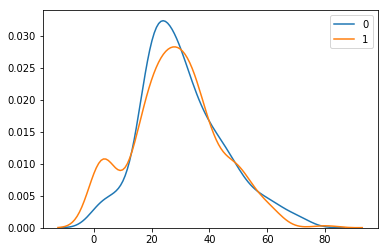

In [52]:
# Age - Age in years
ax = sns.kdeplot(dfx.loc[dfx['Survived'] == 0,'Age'].values, label='0')
ax = sns.kdeplot(dfx.loc[dfx['Survived'] == 1,'Age'].values, label='1')
# only a few intervals help in discriminating, maybe turn into categories...
# todo: test categories of age intervals

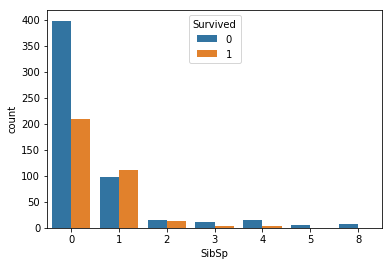

In [53]:
# SibSp - # of siblings / spouses aboard the Titanic
ax = sns.countplot(x='SibSp', hue='Survived', data=dfx)

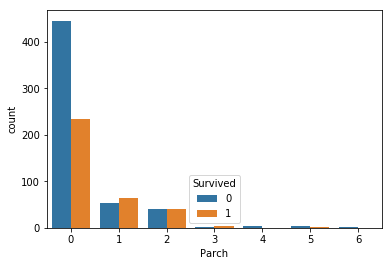

In [54]:
# Parch - # of parents / children aboard the Titanic
ax = sns.countplot(x='Parch', hue='Survived', data=dfx)

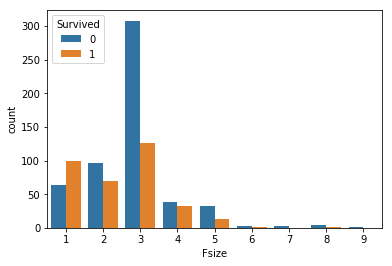

In [55]:
# Fsize - family size - *new
dfx['Fsize'] = dfx['Parch'] + dfx['Pclass']
ax = sns.countplot(x='Fsize', hue='Survived', data=dfx)

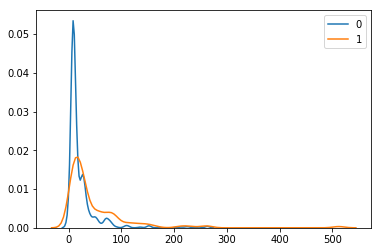

In [56]:
# Fare - Passenger fare
# Age
ax = sns.kdeplot(dfx.loc[dfx['Survived'] == 0,'Fare'].values, label='0')
ax = sns.kdeplot(dfx.loc[dfx['Survived'] == 1,'Fare'].values, label='1')

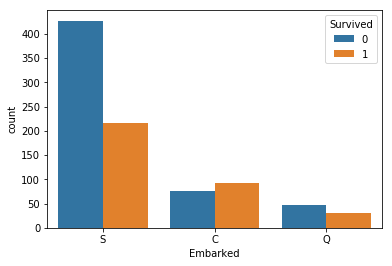

In [57]:
# Embarked - Port of Embarkation -> C = Cherbourg, Q = Queenstown, S = Southampton
ax = sns.countplot(x='Embarked', hue='Survived', data=dfx)

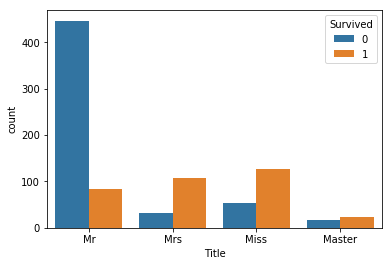

In [58]:
# Title - *new
title_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr',
              'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess','Don', 'Jonkheer']
dfx['Title'] = dfx['Name'].map(lambda x: substrings_in_string(x, title_list))
dfx['Title'] = dfx.apply(replace_titles, axis=1)
ax = sns.countplot(x='Title', hue='Survived', data=dfx)

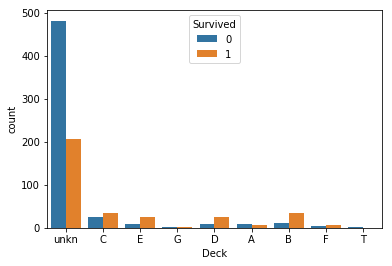

In [59]:
# Deck - extracting info from Cabin variable - *new
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G','unkn']
dfx['Deck'] = dfx['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
ax = sns.countplot(x='Deck', hue='Survived', data=dfx)

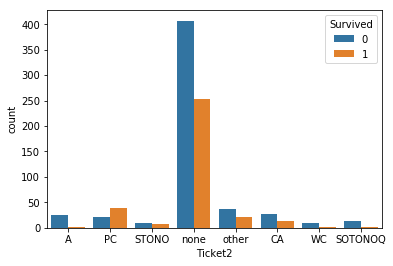

In [60]:
# Ticket info 2 - info extracted from Ticket column - *new
dfx['Ticket2'] = dfx['Ticket'].map(lambda x: ''.join(re.findall('[a-zA-Z]+', x)))
ticket2_values = ['PC','CA','A','STONO','SOTONOQ','WC', 'none']
dfx['Ticket2'] = dfx['Ticket2'].map(lambda x: 'none' if x == '' else x)
dfx['Ticket2'] = dfx['Ticket2'].map(lambda x: x if x in ticket2_values else 'other')
ax = sns.countplot(x='Ticket2', hue='Survived', data=dfx)

In [61]:
def prepare_data(dfx):
    # family size
    dfx['Fsize'] = dfx['Parch'] + dfx['Pclass']
    # title
    title_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr',
                  'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess','Don', 'Jonkheer']
    dfx['Title'] = dfx['Name'].map(lambda x: substrings_in_string(x, title_list))
    dfx['Title'] = dfx.apply(replace_titles, axis=1)
    # deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G','unkn']
    dfx['Deck'] = dfx['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
    # ticket
    ticket2_list = ['PC','CA','A','STONO','SOTONOQ','WC', 'none']
    dfx['Ticket2'] = dfx['Ticket'].map(lambda x: ''.join(re.findall('[a-zA-Z]+', x)))
    dfx['Ticket2'] = dfx['Ticket2'].map(lambda x: 'none' if x == '' else x)
    dfx['Ticket2'] = dfx['Ticket2'].map(lambda x: x if x in ticket2_list else 'other')
    # keeping only needed data
    valid_columns = ['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked',
                     'Fsize','Title','Deck','Ticket2']
    return dfx[[x for x in dfx.columns if x in valid_columns]]

In [62]:
train_data = prepare_data(dfx=train_data_raw.copy())
test_data = prepare_data(dfx=test_data_raw.copy())

In [63]:
# looking for missing data
train_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Fsize         0
Title         0
Deck          0
Ticket2       0
dtype: int64

In [64]:
test_data.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
Fsize        0
Title        0
Deck         0
Ticket2      0
dtype: int64

In [65]:
# for the columns with a few null values, we can go simple
train_data.loc[pd.isnull(train_data['Embarked']), 'Embarked'] = 'C'  # category that discriminates the less
test_data.loc[pd.isnull(test_data['Fare']), 'Fare'] = np.nanmean(np.concatenate((train_data['Fare'].values, test_data['Fare'].values), axis=None))

In [70]:
# age variable -> using regression
age_data = pd.concat([train_data, test_data], sort=False).drop('Survived', axis=1)
categorical_columns = ['Sex', 'Embarked', 'Title', 'Deck', 'Ticket2']
for cat_col in categorical_columns:
    age_data = turn_factors_2_columns(age_data, cat_col)  # cinse is a regression this is the MO
age_data.drop('Sex_male', axis=1, inplace=True)  # binary variable -> no need for 2 columns
age_data_train = age_data.loc[~pd.isnull(age_data['Age'])].copy()
age_data_topred = age_data.loc[pd.isnull(age_data['Age'])].drop(labels=['Age'], axis=1).copy()
(x_age, y_age) = separate_xy(age_data_train, y_col='Age')
glm_model = sm.GLM(y_age, x_age).fit()
predicted_ages = glm_model.predict(age_data_topred.values)
predicted_ages_df = pd.DataFrame({'Age':predicted_ages}, index=age_data_topred.index)
train_data.update(predicted_ages_df)
test_data.update(predicted_ages_df)
# a simpler and fatest way would be using the mean as bellow
# but my tests indicates the regression version performed better
# age_avg = np.nanmean(np.concatenate((train_data['Age'].values, test_data['Age'].values), axis=None))
# train_data.loc[pd.isnull(train_data['Age']), 'Age'] = age_avg
# test_data.loc[pd.isnull(test_data['Age']), 'Age'] = age_avg

In [71]:
# feature engineering done
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fsize,Title,Deck,Ticket2
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,3,Mr,unkn,A
2,1,1,female,38.0,1,0,71.2833,C,1,Mrs,C,PC
3,1,3,female,26.0,0,0,7.9250,S,3,Miss,unkn,STONO
4,1,1,female,35.0,1,0,53.1000,S,1,Mrs,C,none
5,0,3,male,35.0,0,0,8.0500,S,3,Mr,unkn,none


### Predicting

In [73]:
# data with columns values encoded
train_data_enc = train_data.copy()
categorical_columns = ['Sex', 'Embarked', 'Title', 'Deck', 'Ticket2']
encoding_dict = dict()
for enc_col in categorical_columns:
    encoding_dict[enc_col] = preprocessing.LabelEncoder()
    encoding_dict[enc_col].fit(list(set(train_data_enc[enc_col].values)))
    train_data_enc[enc_col] = encoding_dict[enc_col].transform(train_data_enc[enc_col])
train_data_enc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fsize,Title,Deck,Ticket2
PassengerId,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,2,3,2,8,0
2,1,1,0,38.0,1,0,71.2833,0,1,3,2,2
3,1,3,0,26.0,0,0,7.9250,2,3,1,8,4
4,1,1,0,35.0,1,0,53.1000,2,1,3,2,6
5,0,3,1,35.0,0,0,8.0500,2,3,2,8,6


In [74]:
# data with columns values tunt into dummy
train_data_dum = train_data.copy()
categorical_columns = ['Sex', 'Embarked', 'Title', 'Deck', 'Ticket2']
for cat_col in categorical_columns:
    train_data_dum = turn_factors_2_columns(train_data_dum, cat_col)  # cinse is a regression this is the MO
train_data_dum.drop('Sex_male', axis=1, inplace=True)  # binary variable -> no need for 2 columns
train_data_dum.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Fsize,Sex_female,Embarked_C,Embarked_Q,...,Deck_T,Deck_unkn,Ticket2_A,Ticket2_CA,Ticket2_PC,Ticket2_SOTONOQ,Ticket2_STONO,Ticket2_WC,Ticket2_none,Ticket2_other
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,3,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,1,1,38.0,1,0,71.2833,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,3,26.0,0,0,7.9250,3,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,1,1,35.0,1,0,53.1000,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,3,35.0,0,0,8.0500,3,0,0,0,...,0,1,0,0,0,0,0,0,1,0


#### Approaches

In [268]:
# Support Vector Machines
from sklearn import svm
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.4)
    clf = svm.SVC(gamma='auto').fit(X=X_train, y=y_train)
    this_scores.append(clf.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# enc 0.6906410256410257 0.03319894012233747
# dum 0.723076923076923 0.021605512238913733

0.72515406162465 0.01796774120820267


In [269]:
# Stochastic Gradient Descent
from sklearn import linear_model
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.4)
    clf = linear_model.SGDClassifier(max_iter=1000).fit(X=X_train, y=y_train)
    this_scores.append(clf.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# * can vary ramdomly todo: why
# enc 0.7475641025641027 0.047081838746765865
# dum 0.7642307692307694 0.05371687778138154

0.7175350140056023 0.08346654606957171


In [271]:
# Nearest Neighbors Classification
from sklearn.neighbors import KNeighborsClassifier
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.4)
    neigh = KNeighborsClassifier().fit(X=X_train, y=y_train)
    this_scores.append(neigh.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# enc 0.7097435897435898 0.01530642523639738
# dum 0.7208974358974359 0.016909473942356465

0.7170868347338937 0.019455188071916346


In [272]:
# Nearest Centroid Classifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
[xs, ys] = separate_xy(train_data_enc, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.4)
    clf = NearestCentroid().fit(X=X_train, y=y_train)
    this_scores.append(clf.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# todo: why is it equal
# enc 0.6769230769230767 0.018243909577894502
# dum 0.6641025641025641 0.024826816321842412

0.6666666666666667 0.023475996459111442


In [273]:
# Gaussian Process Classification (GPC)
from sklearn.gaussian_process import GaussianProcessClassifier
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.4)
    gpc = GaussianProcessClassifier().fit(X=X_train, y=y_train)
    this_scores.append(gpc.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# enc 0.7020512820512821 0.017659761964319443
# dum 0.7078205128205127 0.02478838777150144

0.7104761904761905 0.021360338814193785


In [274]:
# Decision Trees
from sklearn.tree import DecisionTreeClassifier
[xs, ys] = separate_xy(train_data_enc, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.4)
    clf = DecisionTreeClassifier(max_depth=6).fit(X=X_train, y=y_train)
    this_scores.append(clf.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# enc 0.8023076923076923 0.01821505688085856
# dum 0.7979487179487179 0.021728405438338858

0.8016806722689076 0.02199905200680321


In [275]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.4)
    clf = LogisticRegression(solver='liblinear').fit(X=X_train, y=y_train)
    this_scores.append(clf.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# enc 0.7975641025641026 0.021001393147489927
# dum 0.8188461538461539 0.016471240850279883

0.8123249299719889 0.014737194888477221


In [225]:
# Gradient Tree Boosting
from sklearn.ensemble import GradientBoostingClassifier
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.35)
    clf = GradientBoostingClassifier(max_depth=3).fit(X=X_train, y=y_train)
    this_scores.append(clf.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# enc 0.8232051282051281 0.01719287652742585
# dum 0.8238461538461539 0.019262367203164824
# all data: 0.898989898989899

0.8232051282051281 0.01719287652742585


In [276]:
# Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
this_scores = []
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.4)
    clf = MLPClassifier(hidden_layer_sizes=(len(xs[0])-2, ), max_iter=1500).fit(X=X_train, y=y_train)
    this_scores.append(clf.score(X=X_test, y=y_test))
print(np.mean(this_scores), np.std(this_scores))
# varies randomly
# enc 0.7874358974358975 0.025939290879057383
# dum 0.8064102564102563 0.022334937679723513

/home/tsk/.virtualenvs/jupyter/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8057142857142858 0.019501592879812152


#### Going deepish in some options

In [245]:
# finding parameter
from sklearn.ensemble import GradientBoostingClassifier
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
test_db = []
for it in range(1,13):
    this_scores = []
    for i in range(25):
        X_train, X_test, y_train, y_test = train_test_split(xs, ys.reshape(len(ys)), test_size=0.35)
        clf = GradientBoostingClassifier(max_depth=7).fit(X=X_train, y=y_train)
        this_scores.append(clf.score(X=X_test, y=y_test))
    test_db.append({'depth':it, 'mean':np.mean(this_scores), 'std':np.std(this_scores)})

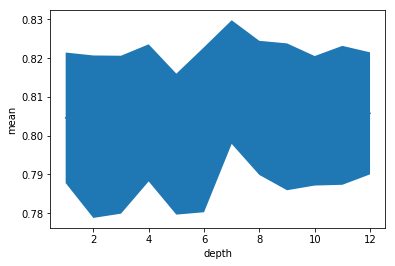

In [265]:
test_df = pd.DataFrame(test_db)
ax = sns.lineplot(x='depth', y='mean', data=test_df)
# ax.errorbar(test_df['depth'], test_df['mean'], yerr=test_df['std'], fmt='-o') #fmt=None to plot bars only
plt.fill_between(test_df['depth'], test_df['mean']-test_df['std'], test_df['mean']+test_df['std'])
plt.show()

In [279]:
# winner?
# Gradient Tree Boosting
from sklearn.ensemble import GradientBoostingClassifier
test_data_dum = test_data.copy()
categorical_columns = ['Sex', 'Embarked', 'Title', 'Deck', 'Ticket2']
for cat_col in categorical_columns:
    test_data_dum = turn_factors_2_columns(test_data_dum, cat_col)
test_data_dum.drop('Sex_male', axis=1, inplace=True)
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
clf = GradientBoostingClassifier(max_depth=5).fit(X=xs, y=ys.reshape(len(ys)))
print(clf.score(X=xs, y=ys.reshape(len(ys))))
test_data_dum['Survived'] = None
[xs_t, ys_t] = separate_xy(test_data_dum, y_col='Survived')
test_labels = clf.predict(xs_t)

0.9629629629629629


#### second best?

In [277]:
from sklearn.linear_model import LogisticRegression
test_data_dum = test_data.copy()
categorical_columns = ['Sex', 'Embarked', 'Title', 'Deck', 'Ticket2']
for cat_col in categorical_columns:
    test_data_dum = turn_factors_2_columns(test_data_dum, cat_col)
test_data_dum.drop('Sex_male', axis=1, inplace=True)
[xs, ys] = separate_xy(train_data_dum, y_col='Survived')
clf = LogisticRegression(solver='liblinear').fit(X=xs, y=ys.reshape(len(ys)))
print(clf.score(X=xs, y=ys.reshape(len(ys))))
test_data_dum['Survived'] = None
[xs_t, ys_t] = separate_xy(test_data_dum, y_col='Survived')
test_labels = clf.predict(xs_t)

0.8327721661054994


#### Saving result for submission

In [278]:
# saving prediction in kaggle format
competition_nickname = 'titanic'
model_tryout_name = 'sklogisticliblinear'
# test_labels = decision_tree.predict(test_data)
pred2_list = test_labels.reshape(len(test_labels))
predicted2 = [random.randint(0,1) if pd.isnull(x) else int(x > 0.5) for x in pred2_list]
results_submission = pd.DataFrame({
                                'PassengerId': test_data_dum.index,
                                'Survived': predicted2
                            })
now = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
results_submission.to_csv('submissions/kaggle_{}_submission_{}_{}.csv'.format(competition_nickname, model_tryout_name, now), index=False)